Setup and Install Dependencies

In [ ]:
# Install required packages
!pip install ultralytics roboflow opencv-python pillow
!pip install -q datasets transformers

In [ ]:


# Import necessary libraries
import os
import json
import cv2
import numpy as np
from pathlib import Path
import shutil
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch

# Check if GPU is available
print(f"GPU Available: {torch.cuda.is_available()}")
print(f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")


Dataset

In [ ]:
import zipfile
import os

zip_path = '/content/dataset/Handglove Detection.v8i.yolov8.zip'
extract_to = '/content/dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction complete.")
print("Extracted folders/files:", os.listdir(extract_to))


In [ ]:
dataset_root = '/content/dataset'
yaml_path = f'{dataset_root}/data.yaml'

print("Dataset root:", dataset_root)
print("YAML path:", yaml_path)


In [ ]:
import yaml

with open(yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)

data_yaml['train'] = f'{dataset_root}/train/images'
data_yaml['val'] = f'{dataset_root}/valid/images'
data_yaml['test'] = f'{dataset_root}/test/images'

with open(yaml_path, 'w') as f:
    yaml.safe_dump(data_yaml, f)

print('Updated data.yaml content:')
with open(yaml_path, 'r') as f:
    print(f.read())


Updated data.yaml content:
names:
- No_Gloves
- Wearing_Gloves
nc: 2
roboflow:
  license: CC BY 4.0
  project: handglove-detection-7ftlj
  url: https://universe.roboflow.com/knowledgeflex/handglove-detection-7ftlj/dataset/8
  version: 8
  workspace: knowledgeflex
test: /content/dataset/test/images
train: /content/dataset/train/images
val: /content/dataset/valid/images



Load and Train YOLOv8 Model

In [ ]:
# Load a pre-trained YOLOv8 model
model = YOLO('yolov8n.pt')  # nano version for faster training

# Train the model
results = model.train(
    data='dataset/data.yaml',  # path to dataset YAML
    epochs=50,                 # number of training epochs
    imgsz=640,                # training image size
    batch=16,                 # batch size
    name='glove_detection',   # experiment name
    patience=5,              # early stopping patience
    save=True,                # save model checkpoints
    cache=True,               # cache images for faster training
    device=0 if torch.cuda.is_available() else 'cpu'  # use GPU if available
)

print("Training completed!")


In [ ]:
import shutil

# Create a new folder to hold everything
import os
os.makedirs('backup_temp', exist_ok=True)
shutil.copytree('dataset', 'backup_temp/dataset', dirs_exist_ok=True)
shutil.copytree('runs', 'backup_temp/runs', dirs_exist_ok=True)

# Now zip the backup_temp folder
shutil.make_archive('project_backup', 'zip', 'backup_temp')


'/content/project_backup.zip'

In [ ]:
from google.colab import files
files.download('project_backup.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
import zipfile

zip_path = 'project_backup.zip'
extract_to = './'  # Extracts to the current working directory

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print('Extraction complete.')


Extraction complete.


Detection Script

In [2]:
import argparse
import json
from pathlib import Path

class GloveDetector:
    def __init__(self, model_path, confidence_threshold=0.5):
        """Initialize the glove detector with trained model"""
        self.model = YOLO(model_path)
        self.confidence_threshold = confidence_threshold
        self.class_names = ['gloved_hand', 'bare_hand']

    def detect_gloves(self, image_path):
        """Detect gloves in a single image"""
        results = self.model(image_path, conf=self.confidence_threshold)

        detections = []
        for result in results:
            boxes = result.boxes
            if boxes is not None:
                for box in boxes:
                    # Get bounding box coordinates
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    confidence = float(box.conf.cpu().numpy())
                    class_id = int(box.cls.cpu().numpy())

                    detection = {
                        "label": self.class_names[class_id],
                        "confidence": round(confidence, 3),
                        "bbox": [int(x1), int(y1), int(x2), int(y2)]
                    }
                    detections.append(detection)

        return detections

    def process_folder(self, input_folder, output_folder, logs_folder):
        """Process all images in a folder"""
        input_path = Path(input_folder)
        output_path = Path(output_folder)
        logs_path = Path(logs_folder)

        # Create output directories
        output_path.mkdir(parents=True, exist_ok=True)
        logs_path.mkdir(parents=True, exist_ok=True)

        # Process each image
        for image_file in input_path.glob("*.jpg"):
            print(f"Processing {image_file.name}...")

            # Detect gloves
            detections = self.detect_gloves(str(image_file))

            # Save detection log
            log_data = {
                "filename": image_file.name,
                "detections": detections
            }

            log_file = logs_path / f"{image_file.stem}.json"
            with open(log_file, 'w') as f:
                json.dump(log_data, f, indent=2)

            # Draw annotations and save
            self.save_annotated_image(str(image_file), detections,
                                    str(output_path / image_file.name))

        print(f"Processing complete! Check {output_folder} for annotated images.")
        print(f"Detection logs saved to {logs_folder}")

    def save_annotated_image(self, image_path, detections, output_path):
        """Save image with bounding box annotations"""
        # Load image
        image = cv2.imread(image_path)

        # Define colors for different classes
        colors = {
            'gloved_hand': (0, 255, 0),    # Green
            'bare_hand': (0, 0, 255)       # Red
        }

        # Draw bounding boxes
        for detection in detections:
            x1, y1, x2, y2 = detection['bbox']
            label = detection['label']
            confidence = detection['confidence']

            # Draw rectangle
            color = colors.get(label, (255, 255, 255))
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

            # Draw label
            label_text = f"{label}: {confidence:.2f}"
            cv2.putText(image, label_text, (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Save annotated image
        cv2.imwrite(output_path, image)

# Initialize detector with trained model
detector = GloveDetector('runs/detect/glove_detection2/weights/best.pt')


Run Detection

In [3]:
import os
from pathlib import Path
import json

# Define your test input, output, and log folders
input_folder = 'dataset/test/images'   # Folder containing test images from your dataset
output_folder = 'inference_output'     # Folder to save annotated images
logs_folder = 'inference_logs'         # Folder to save JSON logs

# Make output and log folders
os.makedirs(output_folder, exist_ok=True)
os.makedirs(logs_folder, exist_ok=True)

# Run detection on test images
if os.listdir(input_folder):
    detector.process_folder(input_folder, output_folder, logs_folder)

    # Display results
    print("\nDetection Results:")
    for log_file in Path(logs_folder).glob('*.json'):
        with open(log_file, 'r') as f:
            data = json.load(f)
            print(f"\n{data['filename']}:")
            for detection in data['detections']:
                print(f"  - {detection['label']}: {detection['confidence']:.3f}")
else:
    print("No images found in the test image folder. Please check your dataset path.")


Processing color76_jpg.rf.e78aef849232cd537533ede98b92b619.jpg...

image 1/1 /content/dataset/test/images/color76_jpg.rf.e78aef849232cd537533ede98b92b619.jpg: 640x640 1 Wearing_Gloves, 424.4ms
Speed: 8.9ms preprocess, 424.4ms inference, 34.4ms postprocess per image at shape (1, 3, 640, 640)
Processing araalam-11-_ani_jpg.rf.24cd2e070bb166b0afe130a9c3e77d77.jpg...



/tmp/ipython-input-147091107.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(box.conf.cpu().numpy())
/tmp/ipython-input-147091107.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_id = int(box.cls.cpu().numpy())


Streaming output truncated to the last 5000 lines.

a-65-_jpg.rf.657c63f0d5ae954c3cf334d72671030b.jpg:

454_jpg.rf.7b5c8007750592ca4bfbecbbed44445c.jpg:
  - gloved_hand: 0.754

pi000_jpg.rf.c42b2309c3ea2acd019e635c20db6ee9.jpg:

AnyConv-com__images-19-_jpg.rf.55fec5a50429574301c076af5f972817.jpg:

mukulam-1-_akh_jpg.rf.ef7263a393ec1be571fac78de542236c.jpg:

sikharam-16-_ani_jpg.rf.b77c6cff5159e20bef7334dfbad238f2.jpg:

araalam-11-_ani_jpg.rf.24cd2e070bb166b0afe130a9c3e77d77.jpg:

oornanabham-9-_ani_jpg.rf.1ef7ec44a8670a4418ea17fd0a02ddae.jpg:

sarpasirassu-20-_ani_jpg.rf.6338cdd77f4215dd43a24ca77770e1ae.jpg:

a-188-_jpg.rf.8fb9a0bf7a90a0194c47430af5e9978a.jpg:
  - bare_hand: 0.697

katakaamukham-14-_akh_jpg.rf.5b9c2600119c1f0c10c9bf8ebb55c021.jpg:

gettyimages-917744736-612x612_jpg.rf.4e1132ecd947b746d74bc1d64e4f5412.jpg:

AnyConv-com__images-39-_jpg.rf.2e8dfda78e254a071cba785dcdc88c45.jpg:

AnyConv-com__hacker-typing-code-on-computer-keyboard-hacker-wearing-gloves-typing-code-on-keybo

Model Evaluation

In [ ]:
# Evaluate the trained model
model = YOLO('runs/detect/glove_detection2/weights/best.pt')

# Run validation
metrics = model.val()

# Print key metrics
print(f"mAP50: {metrics.box.map50:.3f}")
print(f"mAP50-95: {metrics.box.map:.3f}")


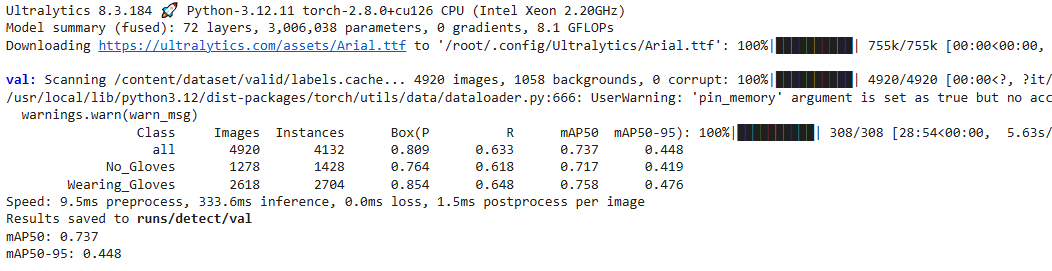

In [8]:
import os
from pathlib import Path
import json
import cv2
from ultralytics import YOLO

model = YOLO('runs/detect/glove_detection2/weights/best.pt')

test_images_folder = Path('dataset/test/images')

output_folder = Path('output')
logs_folder = Path('logs')
output_folder.mkdir(parents=True, exist_ok=True)
logs_folder.mkdir(parents=True, exist_ok=True)

class_names = ['No_Gloves', 'Wearing_Gloves']
sample_images = list(test_images_folder.glob('*.jpg'))[6:11]

for img_path in sample_images:
    print(f"Processing {img_path.name}...")
    # Run prediction
    results = model(str(img_path), conf=0.5)
    detections = []
    boxes = results[0].boxes

    img = cv2.imread(str(img_path))

    # Define colors
    colors = {
        'No_Gloves': (0, 0, 255),      # Red
        'Wearing_Gloves': (0, 255, 0)  # Green
    }

    # Process detections
    if boxes is not None:
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            conf = float(box.conf[0].cpu().numpy())
            cls_id = int(box.cls[0].cpu().numpy())
            label = class_names[cls_id]

            # Append detection to logs
            detections.append({
                "label": label,
                "confidence": round(conf, 3),
                "bbox": [int(x1), int(y1), int(x2), int(y2)]
             })

            # Draw rectangle and label on image
            color = colors[label]
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img, f"{label}: {conf:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    else:
        print(f"No detections for {img_path.name}")

    # Save annotated image
    output_img_path = output_folder / img_path.name
    cv2.imwrite(str(output_img_path), img)

    # Save detection log as JSON
    log_data = {
        "filename": img_path.name,
        "detections": detections
    }
    log_file_path = logs_folder / f"{img_path.stem}.json"
    with open(log_file_path, 'w') as f:
        json.dump(log_data, f, indent=2)

print(f"\nProcessed {len(sample_images)} images.")
print(f"Annotated images saved to: {output_folder.resolve()}")
print(f"Detection logs saved to: {logs_folder.resolve()}")


Processing gettyimages-1266656212-612x612_jpg.rf.0f731ffd32d309ab505635e1bd049251.jpg...

image 1/1 /content/dataset/test/images/gettyimages-1266656212-612x612_jpg.rf.0f731ffd32d309ab505635e1bd049251.jpg: 640x640 (no detections), 220.7ms
Speed: 3.9ms preprocess, 220.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Processing y-71-_jpg.rf.566adc53f839db60f23ee2d7806636a1.jpg...

image 1/1 /content/dataset/test/images/y-71-_jpg.rf.566adc53f839db60f23ee2d7806636a1.jpg: 640x640 1 Wearing_Gloves, 219.1ms
Speed: 5.8ms preprocess, 219.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Processing p104_jpg.rf.c4626159de90559d21dc038341fb5717.jpg...

image 1/1 /content/dataset/test/images/p104_jpg.rf.c4626159de90559d21dc038341fb5717.jpg: 640x640 (no detections), 220.8ms
Speed: 3.8ms preprocess, 220.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Processing sukathundam-5-_ani_jpg.rf.ab69a57f57281ac4448a8eb522983538.jpg...

image 1/1 /cont